In [7]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Funcion Verdadera
def true_function(x):
    return np.sin(2 * np.pi * x) + 0.5 * x**2

N = 80
x = np.sort(np.random.uniform(0, 1, N))
y = true_function(x) + np.random.normal(0, 0.25, N)

x_test = np.linspace(0, 1, 200)
y_true = true_function(x_test)

In [8]:
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

def nadaraya_watson(x_new, x_train, y_train, h):
    """
    Nadaraya-Wastson Kernel regression
    h: bandwidth
    """

    if h <= 0:
        h = 1e-6 # evitar la division por 0
    dist = (x_new - x_train) / h
    weights = gaussian_kernel(dist)
    weights_sum = weights.sum()
    if weights_sum == 0:
        return np.mean(y_train) # fallback
    weights /= weights_sum
    return np.sum(weights * y_train)

    weights = gaussian_kernel((x_new - x_train) / h)
    weights /= weights.sum()  # normalizar
    y_pred = np.sum(weights * y_train)
    return y_pred

<function matplotlib.pyplot.show(close=None, block=None)>

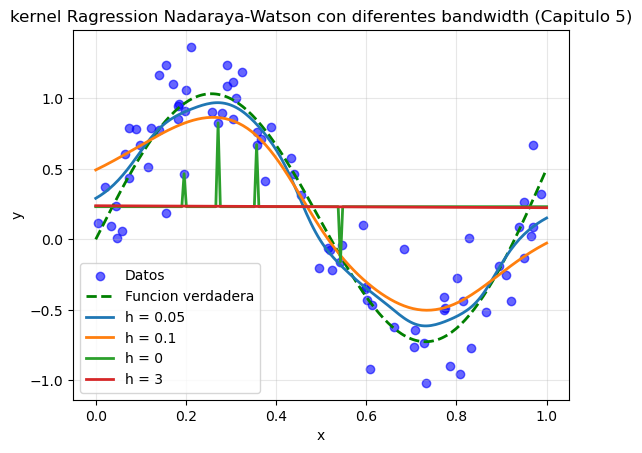

In [9]:
h_values = [0.05, 0.1, 0,3] # bandwidths pequeños, medianos, grandes

plt.Figure(figsize=(12, 8))

plt.scatter(x, y, color='blue', alpha= 0.6, label='Datos')
plt.plot(x_test, y_true, 'g--', linewidth=2, label='Funcion verdadera')

for h in h_values:
    y_pred = np.array([nadaraya_watson(xi, x, y, h) for xi in x_test])
    plt.plot(x_test, y_pred, linewidth=2, label=f'h = {h}')

plt.xlabel('x')
plt.ylabel('y')
plt.title('kernel Ragression Nadaraya-Watson con diferentes bandwidth (Capitulo 5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show    